## `Oligopool Calculator` in Action!

**Author** Ayaan Hossain

**Updated** Sepetember 30, 2024

This `jupyter` notebook will demonstrate the usage of `Oligopool Calculator` and describe how to use its many functions.

### Table of Contents

* [Notebook Setup](#Notebook-Setup)
* [What is Oligopool Calculator?](#What-is-Oligopool-Calculator?)
* [Design Mode Walthrough - An oligopool of 6K ribozyme variants](#Design-Mode-Walkthrough---An-oligopool-of-6K-ribozyme-variants)
    * [Simulating the problem](#Simulating-the-problem)
    * [Reviewing constraints and formulating gameplan](#Reviewing-constraints-and-formulating-gameplan)
    * [Primer design review](#Primer-design-review)
    * [Storing the plasmid background](#Storing-the-plasmid-background)
    * [Designing the three primers](#Designing-the-three-primers)
    * [Designing orthogonal barcodes](#Designing-orthogonal-barcodes)
    * [Adding neutral motifs, spacers and finalizing library](#Adding-neutral-motifs,-spacers-and-finalizing-library)

### Notebook Setup

If you [installed](https://github.com/ayaanhossain/oligopool#Installation) `Oligopool Calculator` successfully, you have everything you need to follow along.

Let's first import `oligopool`.

In [1]:
import oligopool as op

Hopefully, the import worked without throwing up any errors! If you face issues importing, please [open an issue](https://github.com/ayaanhossain/oligopool/issues).

Let us also import `numpy` to do some math, and use `pandas` as our central data container.

In [2]:
import numpy  as np
import pandas as pd

We will also need `matplotlib`/`seaborn` for plotting.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

We're all set.

### What is Oligopool Calculator?

Oligonucleotide pools (oligopools) have revolutionized synthetic biology by enabling large-scale, cost-effective synthesis of hundreds of thousands of unique, short single-stranded DNA sequences through semiconductor-based technology, with major providers leading the market.

These oligopools facilitate the creation and study of various biological components, including de novo promoters, ribozymes, protein scaffolds, and CRISPR libraries. Massively parallel reporter assays (MPRAs) are utilized to clone and assess the functionality of these variants using high-throughput next-generation sequencing (NGS), which can generate billions of short reads per experiment.

Oligopool technology is shaping up to be a cornerstone of contemporary synthetic biology research.

Looking ahead, advancements are expected in the number and length of oligos, NGS throughput, and reductions in manufacturing costs. Successful projects would then require not only core functional variants but also essential components like primers for amplification, spacers for structural integrity, and barcodes for accurate quantification via NGS.

![Oligopool Calculator Workflow](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/workflow.svg)

`Oligopool Calculator` is a comprehensive tool for designing and analyzing large-scale oligonucleotide pools used in synthetic biology research.

In **(a)** `Design Mode`, the algorithms optimize various elements of the oligopool, including barcodes, primers, spacers, and degenerate motifs. It ensures that these components are maximally distinct, non-repetitive, and free from undesired sequences or structures. The tool also enables the splitting of long oligos into shorter fragments with optimized overlaps for downstream assembly.

The **(b)** `Analysis Mode` of the Oligopool Calculator facilitates the processing of next-generation sequencing (NGS) data derived from barcoded amplicons. This mode allows for efficient mapping and counting of variants and their associated barcodes, producing count matrices for quantitative assessment of variant functionality. Two types of counting operations are supported: Association counting for assessing synthesis accuracy, and Combinatorial counting for analyzing multiple barcode combinations from sequencing reads.

Overall `Oligopool Calculator` provides synthetic biologists with a unified platform for oligopool design and characterization, addressing the need for a standardized approach across different projects and labs. This tool eliminates the need for reinventing design scripts or using suboptimal strategies, making it particularly valuable for designing and analyzing pools containing millions of defined variants.

### Design Mode Walkthrough - An oligopool of 6K ribozyme variants

Suppose we want to design and test a library of 6,232 ribozyme variants based on the following architecture.

![Ribozyme Library Architecture](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/architecture.svg)

To characterize the activity of our ribozyme library in _E. coli_ we want to adopt a two-barcode strategy for designing the oligopool. Because ribozymes are self-cleaving, the two barcodes, BC1 and BC2, placed before and after the core variant would be separated after catalysis. This would allow us to count the ratio of their separation to quantify the efficiency of the ribozymes on a proportional scale (i.e., 0 to 100% cleavage efficiency) and normalize against wildtype ribozyme cleavage efficiencies.

#### Simulating the problem

For the purposes of demonstration, let us first generate a random library of 59-73 mers (designing exact ribozymes is beyond the scope here) and assume that the library will be cloned into a 5kb plasmid backbone for characterization, which we will also generate.

In [4]:
rng = np.random.default_rng(seed=42)

In [5]:
dna = ['A', 'T', 'G', 'C']

In [6]:
ribozymes = [''.join(rng.choice(dna, size=rng.integers(low=59, high=74))) for _ in range(6232)]

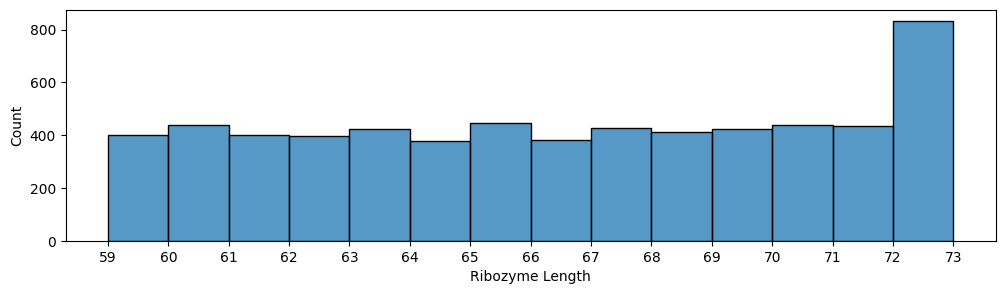

In [7]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
sns.histplot([len(x) for x in ribozymes], binwidth=1)
ax.set_xticks(np.arange(59,74))
ax.set_xlabel('Ribozyme Length')
plt.show()

In [8]:
len(ribozymes)

6232

In [9]:
plasmid = ''.join(rng.choice(dna) for _ in range(5000))

In [10]:
len(plasmid) # 5kbp long plasmid

5000

#### Reviewing constraints and formulating gameplan

So, we have 6,232 simulated candidates, between 59 to 73bp in length and a plasmid of length 5kbp.

We have our simulated library, and we know we want to use `EcoRI` and `AatII` as our restriction sites as part of the characterization process. We can now use `Oligopool Calculator` to design the following.
* Three primers, each 20bp in length,
* The prefix and suffix barcodes each 11bp in length, and
* Variable length spacers ranging from 3 to 17bp to pad the oligos to 170bp.

As constraints, we aim to have the following.
* The primers should not have off-target binding within the library or to the backbone,
* Addition of primers, barcodes or spacers should not introduce `EcoRI` and `AatII` motifs elsewhere or at the junctions (edge effects), and
* The barcodes should all have at least 3 mismatches separating each other.

Other realistic constraints, such as exclusion of all palindomic hexamers, or polymeric runs such as `'AAAAA'`, ..., `'CCCC'` may be included as they were in the original projects, but we will skip those for this demonstration. In reality, constaints will depend on the design project.

How do we begin? By asking `help` from `Oligopool Calculator`.

In [11]:
help(op)

Help on package oligopool:

NAME
    oligopool

DESCRIPTION
    oligopool v2024.09.29
    by ah

    Automated design and analysis of oligopool libraries.

    The various modules in Oligopool Calculator can be used
    interactively in a jupyter notebook, or be used to define
    scripts for design and analysis pipelines on the cloud.

    Oligopool Calculator offers two modes of operation
        -   Design Mode for designing oligopool libraries
        - Analysis Mode for analyzing oligopool datasets

    Design Mode workflow

        1. Initialize a pandas DataFrame with core library elements
            a. The DataFrame must contain a unique 'ID' column serving as primary key
            b. All other columns in the DataFrame must be DNA sequences
        2. Next, define any optional background sequences via the background module
        3. Add necessary oligopool elements with constraints via element modules
        4. Optionally, split long oligos and pad them via assembly module

To begin, per the help, will need to use the `barcode`, `primer`, and `spacer` modules to add the library elements.

#### Primer design review

Generally, primers are the most constrained elements in an oligopool library because they have to conform a desired sequence constrain, free of secondary structures, be very specific to the library and have minimal off-targeting to a background. We recommended designing primers first.

![Primer Design](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/primer.svg)

At any step in the design process if we get stuck, `Oligopool Calculator` will tell us what is preventing it from succeeding and we can relax or modify our constraints accordingly.

How do we design primers? Let's ask for help!

In [12]:
help(op.primer)

Help on function primer in module oligopool.primer:

primer(input_data: str | pandas.core.frame.DataFrame, oligo_length_limit: int, primer_sequence_constraint: str, primer_type: int, minimum_melting_temperature: float, maximum_melting_temperature: float, maximum_repeat_length: int, primer_column: str, output_file: str | None = None, paired_primer_column: str | None = None, left_context_column: str | None = None, right_context_column: str | None = None, excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None, background_directory: str | None = None, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Designs constrained primers with specified melting temperature and non-repetitiveness
    for all variants in the oligopool. Ensures compatibility with paired primers and minimizes
    dimer formation. Returns a DataFrame of designed primers, optionally saving to `output_file`
    in CSV format.

    Required Parameters:
        - `input_data` (`str` / `pd.

Two things should stand out here.

First, primer design involves consideration of background sequences to minimize off-target amplification, such as from the plasmid we set up.

Second, primer design involves consideration of pairing information. If we only had two primers (one forward and one reverse) the order of their design would not matter. But in our problem, there are two forward primers (pink and orange) both of which are coupled to a single reverse primer (yellow). It will be important to design them in the right order, as we will discuss shortly.

Let us first solve the background problem.

#### Storing the plasmid background

`Oligopool Calculator` makes it easy to define a background for primer design via the `background` module.

In [13]:
help(op.background)

Help on function background in module oligopool.background:

background(input_data: list | str | pandas.core.frame.DataFrame, maximum_repeat_length: int, output_directory: str, verbose=True) -> dict
    The background function creates a k-mer database from a list or CSV file of background sequences.
    This database is used during primer design to ensure primers are non-repetitive to the background,
    minimizing off-target amplification. Non-repetitiveness is regulated by the maximum shared repeat
    length parameter. The generated database is saved in the specified `output_directory`.

    Required Parameters:
        - `input_data` (`list` / `str` / `pd.DataFrame`): background for primers; can be a CSV file or a DataFrame.
        - `maximum_repeat_length` (`int`): Max repeat length between primers and background (between 6 and 20).
        - `output_directory` (`str`): Directory to store the generated background k-mer database.
        - `verbose` (`bool`): If `True`, logs updat

> **Note:** If you want to modify the background post-hoc, or want to define your background using a custom strategy, directly use the `vectorDB` module, which behaves like a dictionary. For details use `help(op.vectorDB)`. The `background` module just wraps around it and offers an one-time use simple interface to `vectorDB`.

In [14]:
background_directory = 'demo.oligopool.background'

Let's remove the background if one exists already, for this demonstration.

In [15]:
!rm -rf $background_directory

Execute the `background` module.

In [16]:
background_stats = op.background(
    input_data=plasmid,
    maximum_repeat_length=8,
    output_directory=background_directory)


[Oligopool Calculator: Design Mode - Background]
                                                  
 Required Arguments
 Background      Data: 1 Unique Sequence(s)
    Maximum    Repeat: Up to 8 Base Pair(s) Background Repeats
     Output Directory: demo.oligopool.background               
                                                 
[Computing Background]
 Sequence 1: TGTGCCAACCGACTTCTGAA... Inserted
 Time Elapsed: 0.02 sec                       
                        
[Background Statistics]
 Background Status: Successful
      k-mer  Space: 131,072 Unique 9-mers
       Fill  Count:   4,860 Unique 9-mers (  3.71 %)
       Left  Count: 126,212 Unique 9-mers ( 96.29 %) 
 Time Elapsed: 0.02 sec                              



In [17]:
background_stats

{'status': True,
 'basis': 'solved',
 'step': 1,
 'step_name': 'computing-background',
 'vars': {'kmer_space': 131072, 'fill_count': 4860, 'left_count': 126212},
 'warns': {}}

We've now stored the background, and are ready to design the three primers.

> **Note**: All `Oligopool Calculator` functions return a pipeline statistics dictionary recapitulating the output from the last step performed in the function. If the operation completed successfully, the `status` key will be marked as `True` and `basis` will be marked as `'solved'`.

#### Designing the three primers

All `Design Mode` input and output is mediated through a `pandas` `DataFrame` to facilitate piplined designs. Let us store the variant candidates in a dataframe and start the design process.

In [18]:
df = pd.DataFrame({
    'ID': [f'ribozyme_{x+1:06d}' for x in range(len(ribozymes))],
    'EcoRI': 'GAATTC',
    'Variant':ribozymes,
    'AatII': 'GACGTC',
})

Note that defining the placeholder columns is optional. We are doing it to keep track of all the elements we will need to design.

In [19]:
df.head(5)

,ID,EcoRI,Variant,AatII
0,ribozyme_000001,GAATTC,CGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACT...,GACGTC
1,ribozyme_000002,GAATTC,TCTTCTATCATAGTTAGGCTACGGATCCTCCTCTAGGACACACCCG...,GACGTC
2,ribozyme_000003,GAATTC,GCTGATTCATTCCAACACTCTTGAGGCCGTTTCTATAAACGGTGAC...,GACGTC
3,ribozyme_000004,GAATTC,CATATCTCTGTTCCTCTGCTGTAATCATGAGTCGGATCACTGGTTG...,GACGTC
4,ribozyme_000005,GAATTC,GCATCCGTTGGTAACTTTCAATTGTTCAGGTCTCTGGCTTATCACG...,GACGTC


Given that the primers are coupled, an optimal solution here is to design the innermost (pink) forward primer first, and then design the reverse primer (yellow), followed by designing the outermost (orange) forward primer. This allows all three primers to be compatible with each other.

An alternate solution would involve designing the (yellow) reverse primer first, and then designing the two forward primers successively.

However, if we designed the (yellow) reverse primer at the end, it would be difficult to ensure that it is compatible with both the forward primers simultaneously.

In [20]:
# help(op.primer)

In [21]:
df, stats = op.primer(
    input_data=df,
    oligo_length_limit=170,                    # Must not exceed 170bp at any stage
    primer_sequence_constraint='N'*18 + 'WW',  # The last two bases must be weak
    primer_type=0,                             # This is a forward primer
    primer_column='Pink_Forward_Primer',       # Store designs in 'Pink_Forward_Primer' column
    left_context_column='Variant',             # Next to 'Variant' column
    right_context_column='AatII',              # Before 'AatII' column
    paired_primer_column=None,                 # No paired primer yet
    excluded_motifs=['GAATTC', 'GACGTC'],      # Ensure EcoRI and AatII do not emerge as motifs
    minimum_melting_temperature=53,            # Tm = 53°C at least
    maximum_melting_temperature=55,            # Tm = 55°C at most
    maximum_repeat_length=8,                   # No more than 8-mer repeats allowed
    background_directory=background_directory, # As setup before
    output_file=None,                          # In-memory return, no CSV written here
)


[Oligopool Calculator: Design Mode - Primer]
                                              
 Required Arguments
      Input Data       : DataFrame w/ 6,232 Record(s)
      Oligo Limit      : At most 170 Base Pair(s)     
     Primer Sequence   : A 20 Base Pair IUPAC Constraint
     Primer Type       : Forward Primer Design           
    Melting Temperature: 53 to 55 °C           
     Repeat Length     : Up to 8 Base Pair(s) Oligopool Repeats
     Primer Column     : Output in Column 'Pink_Forward_Primer' 
     Output File       : In-Memory DataFrame                    
                                             
 Optional Arguments
     Paired Primer     : None Specified
       Left Context    : Input from Column 'Variant'
      Right Context    : Input from Column 'AatII'   
   Excluded Motifs     : 2 Unique Motif(s)         
 Background Database   : Contains 4,860 Unique 9-mers
                                                      
[Step 1: Parsing Oligo Limit]
 Maximum Oligo Le

The designed primer is predicted to be free from hairpin structures with low homodimer probability.

Let us now design the two remaining primers in silent mode.

In [22]:
df, _ = op.primer(
    input_data=df,                               # Updated DataFrame along pipeline chain
    oligo_length_limit=170,
    primer_sequence_constraint='WW' + 'N'*18,    # Last two bases must be weak in reverse complement
    primer_type=1,                               # This is a reverse primer
    primer_column='Yellow_Reverse_Primer',       # Store designs in 'Yellow_Reverse_Primer' column
    left_context_column='Pink_Forward_Primer',   # Next to 'Pink_Forward_Primer' column
    right_context_column='AatII',                # Before 'AatII' column
    paired_primer_column='Pink_Forward_Primer',  # Yellow reverse primer paired with pink forward primer
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=8,
    excluded_motifs=['GAATTC', 'GACGTC'],
    background_directory=background_directory,
    output_file=None,                            # In-memory return, no CSV written here
    verbose=False,
)

In [23]:
df, _ = op.primer(
    input_data=df,                                # Updated DataFrame along pipeline chain
    oligo_length_limit=170,
    primer_sequence_constraint='N'*18 + 'WW',     # The last two bases must be weak
    primer_type=0,                                # This is a forward primer
    primer_column='Orange_Forward_Primer',        # Store designs in 'Orange_Forward_Primer' column
    left_context_column='EcoRI',                  # Next to 'EcoRI' column
    right_context_column='Variant',               # Before 'Variant' column
    paired_primer_column='Yellow_Reverse_Primer', # Orange forward primer paired with yellow reverse primer
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=8,
    excluded_motifs=['GAATTC', 'GACGTC'],
    background_directory=background_directory,
    output_file=None,                             # In-memory return, no CSV written here
    verbose=False,
)

In [24]:
df.head(5)

,EcoRI,Orange_Forward_Primer,Variant,Pink_Forward_Primer,Yellow_Reverse_Primer,AatII
ID,,,,,,
ribozyme_000001,GAATTC,ACAAGGGCGGACAGGCTAAT,CGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACT...,ATGAAAGGTGGCGTCGGGTT,ATATCCACCGCATCCCCGAG,GACGTC
ribozyme_000002,GAATTC,ACAAGGGCGGACAGGCTAAT,TCTTCTATCATAGTTAGGCTACGGATCCTCCTCTAGGACACACCCG...,ATGAAAGGTGGCGTCGGGTT,ATATCCACCGCATCCCCGAG,GACGTC
ribozyme_000003,GAATTC,ACAAGGGCGGACAGGCTAAT,GCTGATTCATTCCAACACTCTTGAGGCCGTTTCTATAAACGGTGAC...,ATGAAAGGTGGCGTCGGGTT,ATATCCACCGCATCCCCGAG,GACGTC
ribozyme_000004,GAATTC,ACAAGGGCGGACAGGCTAAT,CATATCTCTGTTCCTCTGCTGTAATCATGAGTCGGATCACTGGTTG...,ATGAAAGGTGGCGTCGGGTT,ATATCCACCGCATCCCCGAG,GACGTC
ribozyme_000005,GAATTC,ACAAGGGCGGACAGGCTAAT,GCATCCGTTGGTAACTTTCAATTGTTCAGGTCTCTGGCTTATCACG...,ATGAAAGGTGGCGTCGGGTT,ATATCCACCGCATCCCCGAG,GACGTC


All our primers are installed. Barcodes up next!

Before that, since we're done with the background let's drop it.

In [25]:
op.vectorDB(background_directory, maximum_repeat_length=11).drop()

True

#### Designing orthogonal barcodes

Barcodes are critical elements that help identify each variant uniquely, especially when the core oligo variants are similar to each other. `Oligopool Calculator` maximizes barcode distinguishability which is useful, for example, when the library is exploring all single substitutions to a template.

![Barcode Design](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/barcode.svg)

In [26]:
help(op.barcode)

Help on function barcode in module oligopool.barcode:

barcode(input_data: str | pandas.core.frame.DataFrame, oligo_length_limit: int, barcode_length: int, minimum_hamming_distance: int, maximum_repeat_length: int, barcode_column: str, output_file: str | None = None, barcode_type: int = 0, left_context_column: str | None = None, right_context_column: str | None = None, excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Generates constrained barcodes, ensuring a minimum Hamming distance between each pair
    and excluding specified motifs, even when flanked by context sequences. The output is a
    DataFrame of designed barcodes, which can be saved as a CSV file if specified.

    Required Parameters:
        - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
        - `oligo_length_limit` (`int`): Maximum allowed oligo length (≥ 4).
      

Unlike primers which need to satisfy global constraints (a hard problem), barcodes are optimized contextually (relatively easier). So, barcodes may be designed after all the primers have been installed.

Let us design BC1 first.

In [27]:
df.columns

Index(['EcoRI', 'Orange_Forward_Primer', 'Variant', 'Pink_Forward_Primer',
       'Yellow_Reverse_Primer', 'AatII'],
      dtype='object')

In [28]:
df, _ = op.barcode(
    input_data=df,
    oligo_length_limit=170,
    barcode_length=11,
    minimum_hamming_distance=3,  # As defined by our goal
    maximum_repeat_length=6,     # To prevent internal hairpins, say
    barcode_column='BC1',
    barcode_type=1,
    left_context_column='Orange_Forward_Primer',
    right_context_column='Variant',
    excluded_motifs=['GAATTC', 'GACGTC'],
    output_file=None,
)


[Oligopool Calculator: Design Mode - Barcode]
                                               
 Required Arguments
    Input Data    : DataFrame w/ 6,232 Record(s)
    Oligo Limit   : At most 170 Base Pair(s)     
  Barcode Length  : Exactly 11 Base Pair(s)  
  Hamming Distance: At least 3 Mismatch(es) per Barcode Pair
   Repeat Length  : Up to 6 Base Pair(s) Oligopool Repeats   
  Barcode Column  : Output in Column 'BC1'                 
   Output File    : In-Memory DataFrame    
                                        
 Optional Arguments
  Barcode Type    : Spectrum Optimized Barcodes
     Left Context : Input from Column 'Orange_Forward_Primer'
    Right Context : Input from Column 'Variant'               
 Excluded Motifs  : 2 Unique Motif(s)           
                                      
[Step 1: Parsing Oligo Limit]
 Maximum Oligo Length:  170 Base Pair(s)
 Input Variant Length:  131 to 145 Base Pair(s)
 Reqd. Barcode Length:   11 Base Pair(s)        
 Free Space Available: 

Most of the barcodes have at least 4 mismatches separating them, with all of them being at least 3 mismatches apart, as intended.

Next, let's add BC2.

In [29]:
df, _ = op.barcode(
    input_data=df,
    oligo_length_limit=170,
    barcode_length=11,
    minimum_hamming_distance=3,
    maximum_repeat_length=6,
    barcode_column='BC2',
    barcode_type=1,
    left_context_column='Pink_Forward_Primer',
    right_context_column='Yellow_Reverse_Primer',
    excluded_motifs=['GAATTC', 'GACGTC'],
    output_file=None,
    verbose=False  # Silent mode
)

In [30]:
df.head(5)

,EcoRI,Orange_Forward_Primer,BC1,Variant,Pink_Forward_Primer,BC2,Yellow_Reverse_Primer,AatII
ID,,,,,,,,
ribozyme_000001,GAATTC,ACAAGGGCGGACAGGCTAAT,GGGCCTAAGCC,CGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACT...,ATGAAAGGTGGCGTCGGGTT,TTCAATGTACC,ATATCCACCGCATCCCCGAG,GACGTC
ribozyme_000002,GAATTC,ACAAGGGCGGACAGGCTAAT,CTACTTAAGAG,TCTTCTATCATAGTTAGGCTACGGATCCTCCTCTAGGACACACCCG...,ATGAAAGGTGGCGTCGGGTT,GGACCGTGCAA,ATATCCACCGCATCCCCGAG,GACGTC
ribozyme_000003,GAATTC,ACAAGGGCGGACAGGCTAAT,AGAAGAGCGGA,GCTGATTCATTCCAACACTCTTGAGGCCGTTTCTATAAACGGTGAC...,ATGAAAGGTGGCGTCGGGTT,TACTCCCTACG,ATATCCACCGCATCCCCGAG,GACGTC
ribozyme_000004,GAATTC,ACAAGGGCGGACAGGCTAAT,GACGGAGAGGC,CATATCTCTGTTCCTCTGCTGTAATCATGAGTCGGATCACTGGTTG...,ATGAAAGGTGGCGTCGGGTT,TTGGGCATTTC,ATATCCACCGCATCCCCGAG,GACGTC
ribozyme_000005,GAATTC,ACAAGGGCGGACAGGCTAAT,CTTTGCCGAAG,GCATCCGTTGGTAACTTTCAATTGTTCAGGTCTCTGGCTTATCACG...,ATGAAAGGTGGCGTCGGGTT,GGCGCGAGGAA,ATATCCACCGCATCCCCGAG,GACGTC


Barcodes are done! The only thing left to design are the spacers so that all oligos have the same length of 170bp.

In [31]:
help(op.lenstat)

Help on function lenstat in module oligopool.lenstat:

lenstat(input_data: str | pandas.core.frame.DataFrame, oligo_length_limit: int, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Computes the length statistics of the elements and the resulting oligos in `input_data`.
    Returns the same input DataFrame (to facilitate pipelining) and the stats dictionary.

    Required Parameters:
        - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
        - `oligo_length_limit` (`int`): Maximum allowed oligo length (≥ 4).

    Returns:
        - A pandas DataFrame of input data, without altering it.
        - A dictionary of stats from the last step in pipeline.

    Notes:
        - `input_data` must contain a unique 'ID' column, all other columns must be non-empty DNA strings.
        - `lenstat` module does not add anything to `input_data`, so there is no `output_file` required.



In [32]:
df, _ = op.lenstat(input_data=df, oligo_length_limit=170);


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 170 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element AatII: Occupies 6 Base Pair(s)                 
 Time Elapsed: 0.01 sec
                        
[Length Statistics]

                           Min     Max    Min    Max    Oligo
                       Element Element  Oligo  Oligo    Limit
                        Length  Length Length Length Overflow
                 EcoRI    6 bp    6 bp   6 bp   6 bp       No
 Orange_Forward_Primer   20 bp   20 bp  26 bp  26 bp       No
                   BC1   11 bp   11 bp  37 bp  37 bp       No
               Variant   59 bp   73 bp  96 bp 110 bp       No
   Pink_Forward_Primer   20 bp   20 bp 116 bp 130 bp       No
                   BC2   11 bp   11 bp 127 bp 141 bp       No
 Yellow_Reverse

We have between 3 to 17 bases that needed to be filled with neutral spacers.

#### Adding neutral motifs, spacers and finalizing library

In [33]:
df.columns

Index(['EcoRI', 'Orange_Forward_Primer', 'BC1', 'Variant',
       'Pink_Forward_Primer', 'BC2', 'Yellow_Reverse_Primer', 'AatII'],
      dtype='object')

The last element in our oligo is a `AatII` restriction site, and we want to add 3 to 17 bases of filler next to it. We can do this using the `spacer` module.

But suppose we wanted to add a filler site based on a degenerate sequence constraint, a motif? We would use the `motif` module instead.

In [34]:
help(op.motif)

Help on function motif in module oligopool.motif:

motif(input_data: str | pandas.core.frame.DataFrame, oligo_length_limit: int, motif_sequence_constraint: str, motif_column: str, output_file: str | None = None, left_context_column: str | None = None, right_context_column: str | None = None, excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Adds a constant or designs constrained motifs free of edge-effects between the given sequence
    contexts. Addition of motifs will not produce excluded motifs unless one was embedded in it.
    Returned DataFrame with added motifs can optionally be saved to a CSV.

    Required Parameters:
        - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
        - `oligo_length_limit` (`int`): Maximum allowed oligo length (≥ 4).
        - `motif_sequence_constraint` (`int`): IUPAC degenerate sequence constra

We will see this function in action by first removing the `AatII` motif column and replacing with a degenerate motif containing the restriction site but with 3 `'N'`s on its right flank.

In [35]:
df = df.drop(columns=['AatII'])

In [36]:
df.columns

Index(['EcoRI', 'Orange_Forward_Primer', 'BC1', 'Variant',
       'Pink_Forward_Primer', 'BC2', 'Yellow_Reverse_Primer'],
      dtype='object')

In [37]:
df, _ = op.motif(
    input_data=df,
    oligo_length_limit=170,
    motif_sequence_constraint='GACGTC'+'NNN', # The AatII motif with right flanking Ns
    motif_column='AatII_Padded',
    left_context_column='Yellow_Reverse_Primer',
    right_context_column=None,
    excluded_motifs=['GAATTC', 'GACGTC'],     # Notice how we are still forbidding the emergence of AatII here
    output_file=None,
)


[Oligopool Calculator: Design Mode - Motif]
                                             
 Required Arguments
    Input Data    : DataFrame w/ 6,232 Record(s)
    Oligo Limit   : At most 170 Base Pair(s)     
    Motif Sequence: A 9 Base Pair IUPAC Constraint
    Motif Column  : Output in Column 'AatII_Padded'
   Output File    : In-Memory DataFrame             
                                        
 Optional Arguments
     Left Context : Input from Column 'Yellow_Reverse_Primer'
    Right Context : None Specified                            
 Excluded Motifs  : 2 Unique Motif(s)
                                      
[Step 1: Parsing Oligo Limit]
 Maximum Oligo Length:  170 Base Pair(s)
 Input Variant Length:  147 to 161 Base Pair(s)
   Reqd. Motif Length:    9 Base Pair(s)        
 Free Space Available:    9 to 23 Base Pair(s)
 Time Elapsed: 0.01 sec                        
 Verdict: Motif Design Possibly Feasible
                                         
[Step 2: Parsing Excluded

Step 3 in the `motif` pipeline warned us about the presence of the `'GACGTC'` in our constraint itself. Nonetheless, the design step was successful.

In [38]:
df, _ = op.lenstat(input_data=df, oligo_length_limit=170)


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 170 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element AatII_Padded: Occupies 9 Base Pair(s)          
 Time Elapsed: 0.01 sec
                        
[Length Statistics]

                           Min     Max    Min    Max    Oligo
                       Element Element  Oligo  Oligo    Limit
                        Length  Length Length Length Overflow
                 EcoRI    6 bp    6 bp   6 bp   6 bp       No
 Orange_Forward_Primer   20 bp   20 bp  26 bp  26 bp       No
                   BC1   11 bp   11 bp  37 bp  37 bp       No
               Variant   59 bp   73 bp  96 bp 110 bp       No
   Pink_Forward_Primer   20 bp   20 bp 116 bp 130 bp       No
                   BC2   11 bp   11 bp 127 bp 141 bp       No
 Yellow_Reverse

We now only need spacers to pad the oligos to 170 bases. Free space available is between 0 to 14 bases.

In [39]:
help(op.spacer)

Help on function spacer in module oligopool.spacer:

spacer(input_data: str | pandas.core.frame.DataFrame, oligo_length_limit: int, spacer_column: str, output_file: str | None = None, spacer_length: int | None = None, left_context_column: str | None = None, right_context_column: str | None = None, excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Inserts a fixed or variable length neutral spacers free from excluded motifs. If the spacer length
    is not specified, then the spacer per oligo is such that the final length of the oligo matches
    specified `oligo_length_limit`. Returned DataFrame can be written as a CSV file.

    Required Parameters:
        - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
        - `oligo_length_limit` (`int`): Maximum allowed oligo length (≥ 4).
        - `motif_column` (`str`): Column name for inserti

`Oligopool Calculator` can flexibly design our variable length spacers.

In [40]:
df, _ = op.spacer(
    input_data=df,
    oligo_length_limit=170, # We will automatically add spacers to match this length
    spacer_column='Spacer',
    left_context_column='AatII_Padded',
    right_context_column=None,
    excluded_motifs=['GAATTC', 'GACGTC'],
    verbose=True)


[Oligopool Calculator: Design Mode - Spacer]
                                              
 Required Arguments
    Input Data   : DataFrame w/ 6,232 Record(s)
    Oligo Limit  : At most 170 Base Pair(s)     
   Spacer Column : Output in Column 'Spacer'
   Output File   : In-Memory DataFrame       
                                       
 Optional Arguments
   Spacer Length : Computed from Oligo Length (Auto-Inferred)
     Left Context: Input from Column 'AatII_Padded'           
    Right Context: None Specified                   
 Excluded Motifs : 2 Unique Motif(s)
                                     
[Step 1: Extracting Spacer Length]
 Variant ribozyme_006232: Allows 3 Base Pair Spacer 
 Time Elapsed: 1.64 sec
                        
[Step 2: Parsing Oligo Limit]
 Maximum Oligo Length:  170 Base Pair(s)
 Input Variant Length:  156 to 170 Base Pair(s)
  Reqd. Spacer Length:    0 to 14 Base Pair(s)  
 Free Space Available:    0 to 14 Base Pair(s) 
 Time Elapsed: 0.00 sec          

In [41]:
df, _ = op.lenstat(input_data=df, oligo_length_limit=170)


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 170 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element Spacer: Occupies 0 to 14 Base Pair(s)          
 Time Elapsed: 0.01 sec
                        
[Length Statistics]

                           Min     Max    Min    Max    Oligo
                       Element Element  Oligo  Oligo    Limit
                        Length  Length Length Length Overflow
                 EcoRI    6 bp    6 bp   6 bp   6 bp       No
 Orange_Forward_Primer   20 bp   20 bp  26 bp  26 bp       No
                   BC1   11 bp   11 bp  37 bp  37 bp       No
               Variant   59 bp   73 bp  96 bp 110 bp       No
   Pink_Forward_Primer   20 bp   20 bp 116 bp 130 bp       No
                   BC2   11 bp   11 bp 127 bp 141 bp       No
 Yellow_Reverse

Our library is complete, all elements have been added, and the oligos are all 170 bases. Let's finalize our library usng the `final` module.

In [42]:
# help(op.final)

In [43]:
final_df, _ = op.final(input_data=df)


[Oligopool Calculator: Design Mode - Final]
                                             
 Required Arguments
  Input Data: DataFrame w/ 6,232 Record(s)
 Output File: In-Memory DataFrame          
                                  
[Step 1: Finalizing Oligopool]
 Finalization Completed         
 Time Elapsed: 0.01 sec 
                        
[Finalization Statistics]
 Final Status: Successful  
 Oligo Length: 170 Base Pair(s)
 Time Elapsed: 0.01 sec         



In [44]:
final_df.head(5)

,CompleteOligo,OligoLength
ID,,
ribozyme_000001,GAATTCACAAGGGCGGACAGGCTAATGGGCCTAAGCCCGTTCAGAA...,170
ribozyme_000002,GAATTCACAAGGGCGGACAGGCTAATCTACTTAAGAGTCTTCTATC...,170
ribozyme_000003,GAATTCACAAGGGCGGACAGGCTAATAGAAGAGCGGAGCTGATTCA...,170
ribozyme_000004,GAATTCACAAGGGCGGACAGGCTAATGACGGAGAGGCCATATCTCT...,170
ribozyme_000005,GAATTCACAAGGGCGGACAGGCTAATCTTTGCCGAAGGCATCCGTT...,170


> **Note** All annotations of the individual oligos are lost in this step. So, we saved it to a new DataFrame. In general, it is a good idea to store the result of each step in `Design Mode` to a separate variable if we were designing our pools interactively, and wanted to roll back.